# Análisis de Inclusión Económica: Predicción de Ingresos (Adult Income Dataset)

## Proyecto: Identificación de Barreras Socioeconómicas y Oportunidades de Inclusión

## Introducción

### 🎯 Contexto del Proyecto

Este proyecto aborda la **inclusión económica y social** mediante el análisis del dataset **Adult Income** (UCI ML Repository), que contiene información socioeconómica de más de 32,000 personas.

### 📊 Objetivo

Identificar **patrones de desigualdad económica** y **barreras de acceso a ingresos altos** (>50K USD/año) para:
- Detectar grupos vulnerables (bajo nivel educativo, sectores de bajos ingresos, brechas de género)
- Entender factores socioeconómicos que limitan el acceso a oportunidades
- Proponer **intervenciones de inclusión** basadas en datos

### 🔍 Preguntas Clave

1. ¿Qué factores determinan el acceso a ingresos altos?
2. ¿Existen brechas de género, edad u ocupación?
3. ¿Cómo impacta la educación en las oportunidades económicas?
4. ¿Qué grupos requieren programas de inclusión prioritarios?

### 📈 Enfoque: Storytelling con Datos

Cada visualización cuenta una historia sobre **inequidad económica** para fundamentar políticas de inclusión social.

### Importación de librerías necesarias

In [79]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
from pathlib import Path
sns.set(style="whitegrid")
pd.options.display.max_columns = 150
pd.options.display.width = 200

### Carga de archivos necesarios

In [80]:
# 2. Cargar los archivos
data_dir = Path(r"c:\Users\usuario\Desktop\bcia\somosf5\eda") / "data"
adult_path = data_dir / "adult.csv"

df_adult = pd.read_csv(adult_path, quotechar='"')

print("adult shape:", df_adult.shape)

# ver primeras filas

display(df_adult.head())

adult shape: (32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### Inspección Rápida: tipos del dato, nulos y valores únicos

In [81]:
# 3. Inspección rápida: tipos, nulos y valores únicos
def quick_overview(df, name):
    print(f"--- OVERVIEW: {name} ---")
    display(df.info())
    print("\nNulos por columna (top 20):")
    display(df.isna().sum().sort_values(ascending=False).head(20))
    print("\nValores únicos (muestra columnas importantes):")
    for c in df.columns[:20]:
        print(f"{c}: {df[c].nunique()} uniques -> sample: {df[c].dropna().unique()[:6]}")
    print("\n\n")

quick_overview(df_adult, "Adult")

--- OVERVIEW: Adult ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None


Nulos por columna (top 20):


age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


Valores únicos (muestra columnas importantes):
age: 73 uniques -> sample: [90 82 66 54 41 34]
workclass: 9 uniques -> sample: ['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc']
fnlwgt: 21648 uniques -> sample: [ 77053 132870 186061 140359 264663 216864]
education: 16 uniques -> sample: ['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school']
education.num: 16 uniques -> sample: [ 9 10  4  6 16 15]
marital.status: 7 uniques -> sample: ['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent']
occupation: 15 uniques -> sample: ['?' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty'
 'Other-service' 'Adm-clerical']
relationship: 6 uniques -> sample: ['Not-in-family' 'Unmarried' 'Own-child' 'Other-relative' 'Husband' 'Wife']
race: 5 uniques -> sample: ['White' 'Black' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
sex: 2 uniques -> sample: ['Female' 'Male']
capital.gain: 119 uniques -> sample: [    0 99999

### Normalización de Valores y conversión de columnas clave

In [82]:
# 4. Limpieza básica: normalizar códigos de 'no responde' y convertir columnas clave
# Reemplazar valores de ausencia habituales ('9','99','999','9999','?','9 ')
no_answer_tokens = {"9","99","999","9999","?","9 ","99 ","999 ","9999 "}
df_adult = df_adult.replace(list(no_answer_tokens), np.nan)

# convertir columnas numéricas
df_adult["age"] = pd.to_numeric(df_adult["age"], errors="coerce")
df_adult["hours.per.week"] = pd.to_numeric(df_adult["hours.per.week"], errors="coerce")

# ver resumen después de limpiar
display(df_adult[["age","hours.per.week"]].describe())

,age,hours.per.week
count,32561.000000,32561.000000
mean,38.581647,40.437456
std,13.640433,12.347429
min,17.000000,1.000000
25%,28.000000,40.000000
50%,37.000000,40.000000
75%,48.000000,45.000000
max,90.000000,99.000000


### Visualización de datos preeliminar

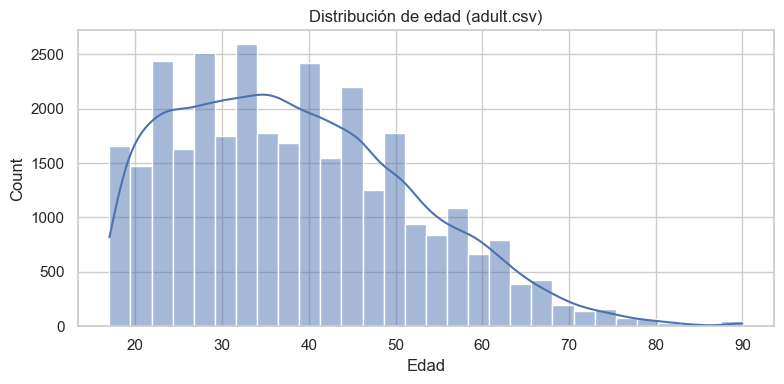

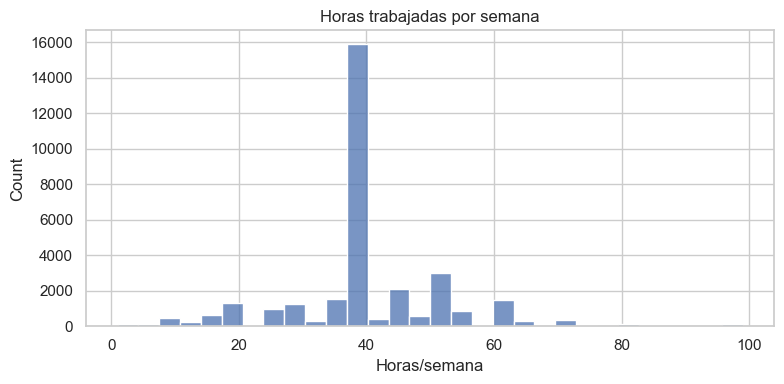

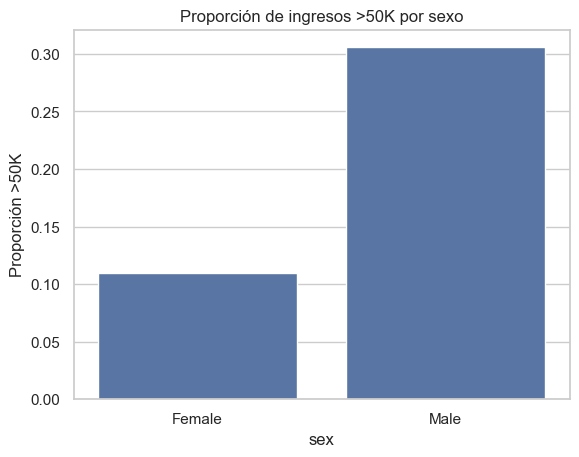

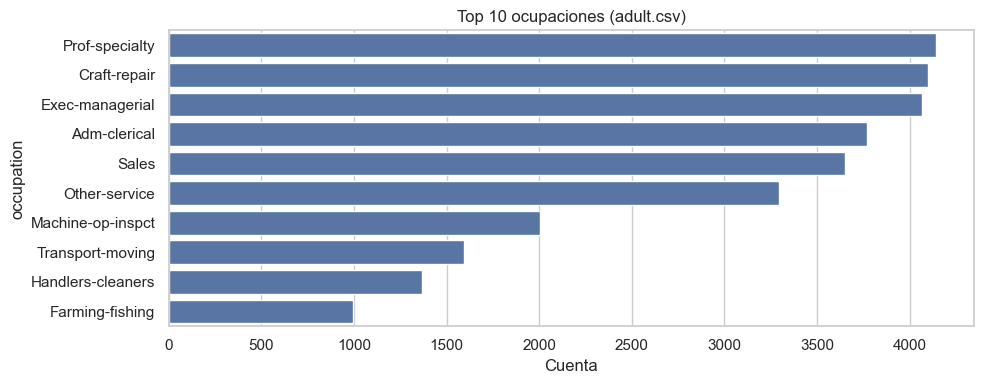

In [83]:
# 5. Visualizaciones ejemplo 
# 5.1 Distribución de edad
plt.figure(figsize=(8,4))
sns.histplot(x=df_adult["age"].dropna(), bins=30, kde=True)
plt.title("Distribución de edad (adult.csv)")
plt.xlabel("Edad")
plt.tight_layout()
plt.show()

# 5.2 Distribución horas por semana
plt.figure(figsize=(8,4))
sns.histplot(x=df_adult["hours.per.week"].dropna(), bins=30)
plt.title("Horas trabajadas por semana")
plt.xlabel("Horas/semana")
plt.tight_layout()
plt.show()

# 5.3 Proporción de income >50K por sexo
if "sex" in df_adult.columns and "income" in df_adult.columns:
    tmp = df_adult.groupby("sex")["income"].apply(lambda x: (x==">50K").mean()).reset_index(name="pct_over50k")
    sns.barplot(data=tmp, x="sex", y="pct_over50k")
    plt.ylabel("Proporción >50K")
    plt.title("Proporción de ingresos >50K por sexo")
    plt.show()

# 5.4 Top ocupaciones (si existe occupation)
if "occupation" in df_adult.columns:
    plt.figure(figsize=(10,4))
    top_occ = df_adult["occupation"].value_counts(dropna=True).head(10)
    sns.barplot(x=top_occ.values, y=top_occ.index)
    plt.title("Top 10 ocupaciones (adult.csv)")
    plt.xlabel("Cuenta")
    plt.tight_layout()
    plt.show()

### Datos faltantes

<Figure size 1000x400 with 0 Axes>

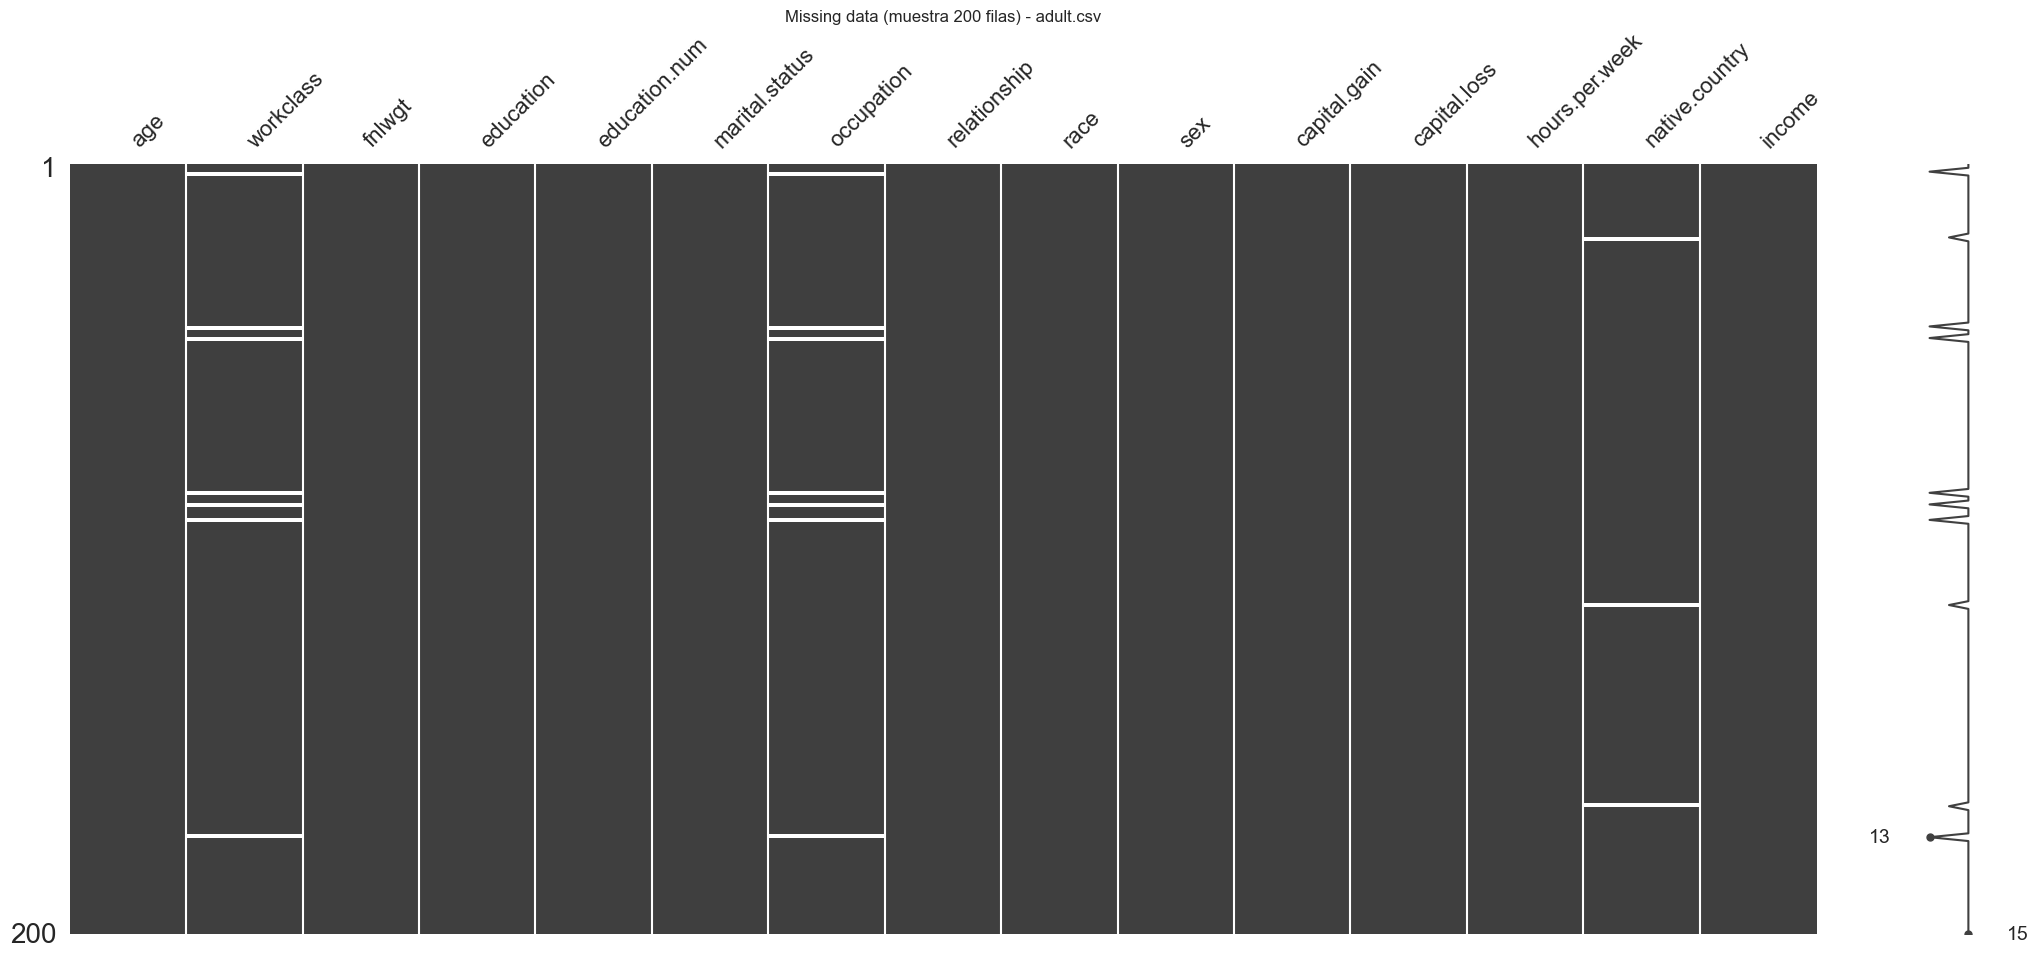

In [84]:
# 7. Missingness visualization (útil para storytelling: "qué falta en los datos")
plt.figure(figsize=(10,4))
msno.matrix(df_adult.sample(min(200, len(df_adult))))
plt.title("Missing data (muestra 200 filas) - adult.csv")
plt.show()

## Primeras impresiones

### 💡 Primeras Impresiones: ¿Por qué es importante la inclusión económica?

El acceso a ingresos dignos no solo se trata de dinero, sino de:
- **Movilidad social**: Capacidad de mejorar condiciones de vida
- **Equidad de oportunidades**: Todos deberían tener acceso a trabajos bien remunerados
- **Desarrollo humano**: Ingresos adecuados permiten acceso a salud, educación, vivienda

**El problema**: No todas las personas tienen las mismas oportunidades, incluso con esfuerzo equivalente.

**Nuestro rol**: Usar datos para identificar dónde están las barreras y cómo derribarlas.

In [85]:
# Variables clave en el dataset para análisis de inclusión económica:

print("=" * 70)
print("VARIABLES CLAVE PARA INCLUSIÓN ECONÓMICA")
print("=" * 70)

print("\n📊 Variables disponibles en Adult Income Dataset:")
print("\n1. DEMOGRÁFICAS:")
print("   - age: Edad de la persona")
print("   - sex: Género (potencial brecha salarial)")
print("   - race: Origen étnico")

print("\n2. EDUCATIVAS:")
print("   - education: Nivel educativo alcanzado")
print("   - education_num: Años de escolaridad (numérico)")

print("\n3. LABORALES:")
print("   - occupation: Tipo de trabajo")
print("   - workclass: Sector (privado, público, autónomo)")
print("   - hours_per_week: Horas trabajadas")

print("\n4. ECONÓMICAS:")
print("   - income: Variable objetivo (≤50K vs >50K USD/año)")
print("   - capital_gain/loss: Ganancias de capital")

print("\n5. CONTEXTUALES:")
print("   - marital_status: Estado civil")
print("   - relationship: Relación familiar")
print("   - native_country: País de origen")

print("\n🎯 ENFOQUE DEL ANÁLISIS:")
print("   → Identificar qué factores predicen BAJOS INGRESOS (≤50K)")
print("   → Detectar grupos en situación de vulnerabilidad económica")
print("   → Proponer intervenciones de inclusión social basadas en evidencia")
print("=" * 70)

VARIABLES CLAVE PARA INCLUSIÓN ECONÓMICA

📊 Variables disponibles en Adult Income Dataset:

1. DEMOGRÁFICAS:
   - age: Edad de la persona
   - sex: Género (potencial brecha salarial)
   - race: Origen étnico

2. EDUCATIVAS:
   - education: Nivel educativo alcanzado
   - education_num: Años de escolaridad (numérico)

3. LABORALES:
   - occupation: Tipo de trabajo
   - workclass: Sector (privado, público, autónomo)
   - hours_per_week: Horas trabajadas

4. ECONÓMICAS:
   - income: Variable objetivo (≤50K vs >50K USD/año)
   - capital_gain/loss: Ganancias de capital

5. CONTEXTUALES:
   - marital_status: Estado civil
   - relationship: Relación familiar
   - native_country: País de origen

🎯 ENFOQUE DEL ANÁLISIS:
   → Identificar qué factores predicen BAJOS INGRESOS (≤50K)
   → Detectar grupos en situación de vulnerabilidad económica
   → Proponer intervenciones de inclusión social basadas en evidencia


# Limpieza de Data

In [86]:
from pathlib import Path
import random
random.seed(42)
pd.options.mode.chained_assignment = None

In [87]:
# trabajar sobre copia
df = df_adult.copy()

### Paso 1: Normalizar nombres de columnas

In [88]:
# 1) Normalizar nombres de columnas
df.columns = (df.columns
              .str.strip()
              .str.lower()
              .str.replace(r'[^0-9a-z]+','_', regex=True)
              .str.strip('_'))

print("Columnas después de normalizar:")
print(df.columns.tolist())

Columnas después de normalizar:
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


In [89]:
# 2) Convertir columnas numéricas a tipo numérico
num_cols = ['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']
num_cols = [c for c in num_cols if c in df.columns]

print(f"Convirtiendo {len(num_cols)} columnas numéricas: {num_cols}")

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    
print("\nTipos de datos después de conversión:")
display(df[num_cols].dtypes)

Convirtiendo 6 columnas numéricas: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

Tipos de datos después de conversión:


age               int64
fnlwgt            int64
education_num     int64
capital_gain      int64
capital_loss      int64
hours_per_week    int64
dtype: object

### Paso 2: Convertir columnas numéricas

ANÁLISIS DE VALORES NULOS


,columna,nulos,porcentaje
occupation,occupation,1843,5.66
workclass,workclass,1836,5.64
native_country,native_country,583,1.79


C:\Users\usuario\AppData\Local\Temp\ipykernel_8196\2483409002.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_missing, x='porcentaje', y='columna', palette='viridis')


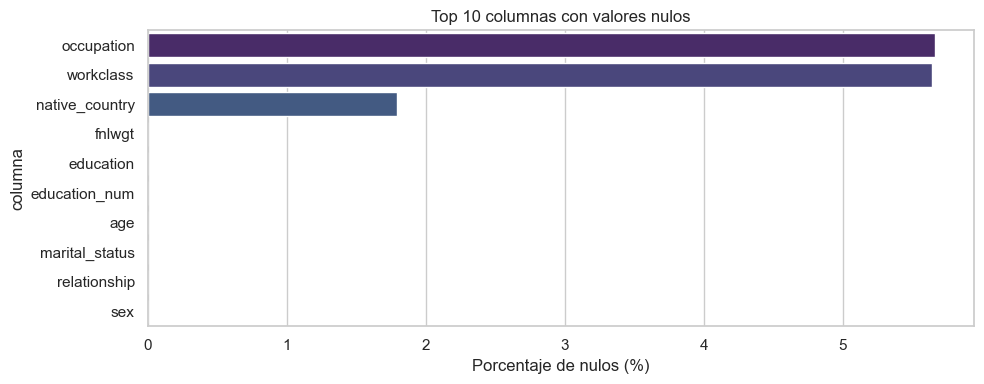

In [90]:
# 3) Análisis de valores nulos
print("=" * 60)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 60)

missing_info = pd.DataFrame({
    'columna': df.columns,
    'nulos': df.isna().sum(),
    'porcentaje': (df.isna().mean() * 100).round(2)
}).sort_values('porcentaje', ascending=False)

display(missing_info[missing_info['nulos'] > 0])

# Visualización
plt.figure(figsize=(10, 4))
top_missing = missing_info.head(10)
sns.barplot(data=top_missing, x='porcentaje', y='columna', palette='viridis')
plt.title('Top 10 columnas con valores nulos')
plt.xlabel('Porcentaje de nulos (%)')
plt.tight_layout()
plt.show()

### Paso 4: Tratamiento especial de 'occupation' (columna clave para inclusión)

In [91]:
# 4) Tratamiento de 'occupation' - columna importante para análisis de inclusión
print("=" * 60)
print("TRATAMIENTO DE OCCUPATION")
print("=" * 60)

print(f"\nOccupation - % missing: {df['occupation'].isna().mean()*100:.2f}%")
print(f"Valores únicos: {df['occupation'].nunique()}")

# Ver distribución
print("\nTop 10 ocupaciones:")
display(df['occupation'].value_counts(dropna=False).head(10))

# 1) Crear indicador de missing (preserva información de ausencia)
df['occupation_missing'] = df['occupation'].isna().astype(int)
print(f"\nIndicador de missing creado: {df['occupation_missing'].sum()} casos sin ocupación")

# 2) Imputar con 'Unknown' 
df['occupation'] = df['occupation'].fillna('Unknown')

# 3) Normalizar y agrupar en categorías amplias (útil para modelado)
occ_map = {
    'exec-managerial': 'Management',
    'prof-specialty': 'Professional',
    'tech-support': 'Technical',
    'craft-repair': 'Skilled-labor',
    'machine-op-inspct': 'Skilled-labor',
    'transport-moving': 'Skilled-labor',
    'adm-clerical': 'Clerical',
    'sales': 'Sales',
    'other-service': 'Service',
    'priv-house-serv': 'Service',
    'handlers-cleaners': 'Manual',
    'armed-forces': 'Military',
    'farming-fishing': 'Manual',
    'protective-serv': 'Military',
    'unknown': 'Unknown'
}

# Normalizar nombres
df['occupation_norm'] = (df['occupation']
                         .str.strip()
                         .str.lower()
                         .str.replace(r'[^0-9a-z\-]+', '_', regex=True)
                         .str.replace('_', '-'))

# Mapear a grupos
df['occ_group'] = df['occupation_norm'].map(occ_map).fillna('Other')

print("\nDistribución por grupos de ocupación:")
display(df['occ_group'].value_counts())

# 4) Crear feature de frecuencia (encoding útil para modelos)
occ_freq = df['occ_group'].value_counts(normalize=True)
df['occ_freq'] = df['occ_group'].map(occ_freq)

print("\nSample de features creadas:")
display(df[['occupation', 'occ_group', 'occupation_missing', 'occ_freq']].head(10))

TRATAMIENTO DE OCCUPATION

Occupation - % missing: 5.66%
Valores únicos: 14

Top 10 ocupaciones:


occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
NaN                  1843
Transport-moving     1597
Handlers-cleaners    1370
Name: count, dtype: int64


Indicador de missing creado: 1843 casos sin ocupación

Distribución por grupos de ocupación:

Distribución por grupos de ocupación:


occ_group
Skilled-labor    7698
Professional     4140
Management       4066
Clerical         3770
Sales            3650
Service          3444
Manual           2364
Unknown          1843
Technical         928
Military          658
Name: count, dtype: int64


Sample de features creadas:


,occupation,occ_group,occupation_missing,occ_freq
0,Unknown,Unknown,1,0.056601
1,Exec-managerial,Management,0,0.124873
2,Unknown,Unknown,1,0.056601
3,Machine-op-inspct,Skilled-labor,0,0.236418
4,Prof-specialty,Professional,0,0.127146
5,Other-service,Service,0,0.105771
6,Adm-clerical,Clerical,0,0.115783
7,Prof-specialty,Professional,0,0.127146
8,Prof-specialty,Professional,0,0.127146
9,Craft-repair,Skilled-labor,0,0.236418


### Paso 5: Imputación de valores nulos (otras columnas)

### Paso 3: Análisis de valores nulos

In [92]:
# 5) Imputación de valores nulos para el resto de columnas
print("=" * 60)
print("IMPUTACIÓN DE VALORES NULOS")
print("=" * 60)

# Columnas numéricas ya definidas - imputar con mediana
print("\n[Numéricas] Imputando con mediana:")
for c in num_cols:
    if c in df.columns:
        n_missing = df[c].isna().sum()
        if n_missing > 0:
            med = df[c].median()
            df[c].fillna(med, inplace=True)
            print(f"  {c}: {n_missing} valores → mediana = {med:.2f}")

# Columnas categóricas - imputar con 'Unknown'
# Excluir: income (target), occupation (ya tratada), y features generadas
exclude_cols = {'income', 'occupation', 'occupation_norm', 'occ_group', 
                'occupation_missing', 'occ_freq'}

cat_cols = [c for c in df.select_dtypes(include='object').columns 
            if c not in exclude_cols]

print(f"\n[Categóricas] Imputando con 'Unknown' en {len(cat_cols)} columnas:")
for c in cat_cols:
    n_missing = df[c].isna().sum()
    if n_missing > 0:
        df[c].fillna('Unknown', inplace=True)
        print(f"  {c}: {n_missing} valores → 'Unknown'")

# Verificar que no quedan nulos (excepto si se eliminaron columnas)
print("\n" + "=" * 60)
remaining_nulls = df.isna().sum().sum()
print(f"Total de valores nulos restantes: {remaining_nulls}")
if remaining_nulls > 0:
    print("⚠️ Aún hay valores nulos en:")
    display(df.isna().sum()[df.isna().sum() > 0])

IMPUTACIÓN DE VALORES NULOS

[Numéricas] Imputando con mediana:

[Categóricas] Imputando con 'Unknown' en 7 columnas:
  workclass: 1836 valores → 'Unknown'
  native_country: 583 valores → 'Unknown'

Total de valores nulos restantes: 0
  workclass: 1836 valores → 'Unknown'
  native_country: 583 valores → 'Unknown'

Total de valores nulos restantes: 0


C:\Users\usuario\AppData\Local\Temp\ipykernel_8196\2735002489.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna('Unknown', inplace=True)


### Paso 6: Crear variable target (income_bin)

In [93]:
# 6) Crear variable target binaria
print("=" * 60)
print("CREACIÓN DE VARIABLE TARGET")
print("=" * 60)

if 'income' in df.columns:
    # Ver distribución original
    print("\nDistribución original de income:")
    display(df['income'].value_counts())
    
    # Crear variable binaria
    df['income_bin'] = df['income'].str.strip().map({'>50K': 1, '<=50K': 0})
    
    # Verificar mapeo
    print("\nDistribución de income_bin:")
    display(df['income_bin'].value_counts())
    print(f"Proporción de >50K: {df['income_bin'].mean():.2%}")
    
    # Eliminar filas sin target válido
    n_before = len(df)
    df = df[df['income_bin'].notna()].copy()
    n_removed = n_before - len(df)
    
    if n_removed > 0:
        print(f"\n⚠️ Filas sin target válido eliminadas: {n_removed}")
    
    # Eliminar columna original
    df.drop(columns=['income'], inplace=True)
    print("\n✓ Variable target 'income_bin' creada correctamente")
else:
    print("⚠️ Columna 'income' no encontrada")

CREACIÓN DE VARIABLE TARGET

Distribución original de income:


income
<=50K    24720
>50K      7841
Name: count, dtype: int64


Distribución de income_bin:


income_bin
0    24720
1     7841
Name: count, dtype: int64

Proporción de >50K: 24.08%

✓ Variable target 'income_bin' creada correctamente


### Paso 7: Eliminar duplicados

In [94]:
# 7) Eliminar duplicados
print("=" * 60)
print("ELIMINACIÓN DE DUPLICADOS")
print("=" * 60)

n_dup = df.duplicated().sum()
print(f"\nFilas duplicadas encontradas: {n_dup}")

if n_dup > 0:
    df.drop_duplicates(inplace=True)
    print(f"✓ {n_dup} filas duplicadas eliminadas")
else:
    print("✓ No hay filas duplicadas")
    
print(f"\nShape actual del dataset: {df.shape}")

ELIMINACIÓN DE DUPLICADOS

Filas duplicadas encontradas: 24
✓ 24 filas duplicadas eliminadas

Shape actual del dataset: (32537, 19)


### Paso 8: Selección de columnas para modelado

In [95]:
# 8) Selección de columnas para modelado
print("=" * 60)
print("SELECCIÓN DE COLUMNAS PARA MODELADO")
print("=" * 60)

# Columnas a eliminar (no útiles para predicción)
# fnlwgt: peso de muestreo, no tiene valor predictivo directo
# occupation: ya creamos occ_group que es más útil
# occupation_norm: variable intermedia
cols_to_drop = ['fnlwgt', 'occupation', 'occupation_norm']
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

if cols_to_drop:
    print(f"\nEliminando columnas no útiles para modelado: {cols_to_drop}")
    df.drop(columns=cols_to_drop, inplace=True)

print(f"\n✓ Dataset limpio - shape: {df.shape}")
print(f"\nColumnas finales ({len(df.columns)}):")
print(df.columns.tolist())

# Resumen de tipos
print("\nTipos de datos:")
display(df.dtypes.value_counts())

SELECCIÓN DE COLUMNAS PARA MODELADO

Eliminando columnas no útiles para modelado: ['fnlwgt', 'occupation', 'occupation_norm']

✓ Dataset limpio - shape: (32537, 16)

Columnas finales (16):
['age', 'workclass', 'education', 'education_num', 'marital_status', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'occupation_missing', 'occ_group', 'occ_freq', 'income_bin']

Tipos de datos:


object     8
int64      7
float64    1
Name: count, dtype: int64

### Paso 9: Crear dataset para modelado (con one-hot encoding)

In [96]:
# 9) Crear versión para modelado con one-hot encoding
print("=" * 60)
print("PREPARACIÓN FINAL PARA MODELADO")
print("=" * 60)

# Identificar columnas categóricas a codificar
# Excluir: target (income_bin), features numéricas ya creadas, indicadores
exclude_from_encoding = {'income_bin', 'occupation_missing', 'occ_freq'}

cat_cols_to_encode = [c for c in df.select_dtypes(include='object').columns 
                      if c not in exclude_from_encoding]

print(f"\nColumnas categóricas a codificar ({len(cat_cols_to_encode)}):")
for col in cat_cols_to_encode:
    print(f"  - {col}: {df[col].nunique()} categorías")

# Crear dataset con one-hot encoding
print("\nAplicando one-hot encoding...")
df_model = pd.get_dummies(df, columns=cat_cols_to_encode, drop_first=True)

print(f"\n✓ Dataset de modelado creado")
print(f"  Shape original: {df.shape}")
print(f"  Shape con encoding: {df_model.shape}")
print(f"  Nuevas features creadas: {df_model.shape[1] - df.shape[1]}")

# Verificar tipos finales
print(f"\nTipos de datos finales:")
display(df_model.dtypes.value_counts())

# Mostrar sample
print("\nSample de datos finales:")
display(df_model.head())

PREPARACIÓN FINAL PARA MODELADO

Columnas categóricas a codificar (8):
  - workclass: 9 categorías
  - education: 16 categorías
  - marital_status: 7 categorías
  - relationship: 6 categorías
  - race: 5 categorías
  - sex: 2 categorías
  - native_country: 42 categorías
  - occ_group: 10 categorías

Aplicando one-hot encoding...

✓ Dataset de modelado creado
  Shape original: (32537, 16)
  Shape con encoding: (32537, 97)
  Nuevas features creadas: 81

Tipos de datos finales:


bool       89
int64       7
float64     1
Name: count, dtype: int64


Sample de datos finales:


,age,education_num,capital_gain,capital_loss,hours_per_week,occupation_missing,occ_freq,income_bin,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native_country_Canada,native_country_China,native_country_Columbia,native_country_Cuba,native_country_Dominican-Republic,native_country_Ecuador,native_country_El-Salvador,native_country_England,native_country_France,native_country_Germany,native_country_Greece,native_country_Guatemala,native_country_Haiti,native_country_Holand-Netherlands,native_country_Honduras,native_country_Hong,native_country_Hungary,native_country_India,native_country_Iran,native_country_Ireland,native_country_Italy,native_country_Jamaica,native_country_Japan,native_country_Laos,native_country_Mexico,native_country_Nicaragua,native_country_Outlying-US(Guam-USVI-etc),native_country_Peru,native_country_Philippines,native_country_Poland,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Unknown,native_country_Vietnam,native_country_Yugoslavia,occ_group_Management,occ_group_Manual,occ_group_Military,occ_group_Professional,occ_group_Sales,occ_group_Service,occ_group_Skilled-labor,occ_group_Technical,occ_group_Unknown
0,90,9,0,4356,40,1,0.056601,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
1,82,9,0,4356,18,0,0.124873,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False
2,66,10,0,4356,40,1,0.056601,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
3,54,4,0,3900,40,0,0.236418,0,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,Fals

### Paso 10: Guardar datasets limpios

In [97]:
# 10) Guardar datasets limpios
print("=" * 60)
print("GUARDANDO DATASETS")
print("=" * 60)

# Crear directorio si no existe
processed_dir = Path(r"c:\Users\usuario\Desktop\bcia\somosf5\eda") / "data" / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

# Guardar dataset limpio (sin encoding - útil para análisis)
csv_path = processed_dir / "adult_clean.csv"
df.to_csv(csv_path, index=False)
print(f"\n✓ Dataset limpio guardado: {csv_path}")
print(f"  Shape: {df.shape}")

# Guardar dataset para modelado (con encoding - listo para ML)
# Usar CSV en lugar de parquet para evitar conflictos
csv_model_path = processed_dir / "adult_clean_model.csv"
df_model.to_csv(csv_model_path, index=False)
print(f"\n✓ Dataset para modelado guardado: {csv_model_path}")
print(f"  Shape: {df_model.shape}")

# Crear diccionario de datos
metadata = {
    'fecha_procesamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
    'filas': len(df),
    'columnas_clean': len(df.columns),
    'columnas_model': len(df_model.columns),
    'target': 'income_bin',
    'features_clave': ['age', 'education_num', 'occ_group', 'hours_per_week', 'occupation_missing']
}

print(f"\n{'=' * 60}")
print("RESUMEN FINAL")
print(f"{'=' * 60}")
for k, v in metadata.items():
    print(f"{k}: {v}")
    
print("\n✓ ¡Limpieza completada con éxito!")

GUARDANDO DATASETS

✓ Dataset limpio guardado: c:\Users\usuario\Desktop\bcia\somosf5\eda\data\processed\adult_clean.csv
✓ Dataset limpio guardado: c:\Users\usuario\Desktop\bcia\somosf5\eda\data\processed\adult_clean.csv
  Shape: (32537, 16)

  Shape: (32537, 16)

✓ Dataset para modelado guardado: c:\Users\usuario\Desktop\bcia\somosf5\eda\data\processed\adult_clean_model.csv
  Shape: (32537, 97)

RESUMEN FINAL
fecha_procesamiento: 2025-10-28 10:32
filas: 32537
columnas_clean: 16
columnas_model: 97
target: income_bin
features_clave: ['age', 'education_num', 'occ_group', 'hours_per_week', 'occupation_missing']

✓ ¡Limpieza completada con éxito!

✓ Dataset para modelado guardado: c:\Users\usuario\Desktop\bcia\somosf5\eda\data\processed\adult_clean_model.csv
  Shape: (32537, 97)

RESUMEN FINAL
fecha_procesamiento: 2025-10-28 10:32
filas: 32537
columnas_clean: 16
columnas_model: 97
target: income_bin
features_clave: ['age', 'education_num', 'occ_group', 'hours_per_week', 'occupation_missing'

---

# 📊 Análisis Post-Limpieza: Storytelling con Datos

## ¿Qué patrones de inequidad encontramos en el acceso a ingresos?

En esta sección exploramos los datos limpios para identificar brechas de inclusión relacionadas con:
- **Género y edad**: ¿Quiénes tienen menor acceso a ingresos altos?
- **Ocupación**: ¿Qué sectores presentan mayor desigualdad?
- **Educación**: ¿Cuál es el impacto real de la formación?

Cada visualización cuenta una historia que nos ayuda a entender **dónde y por qué** debemos actuar.

### 📈 Visualización 1: La Brecha de Género en Ingresos

**Historia**: Las mujeres históricamente han enfrentado barreras para acceder a ingresos altos. ¿Sigue siendo así en estos datos?

C:\Users\usuario\AppData\Local\Temp\ipykernel_8196\1276230776.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_income, x='sex', y='mean', palette='Set2', ax=axes[0])


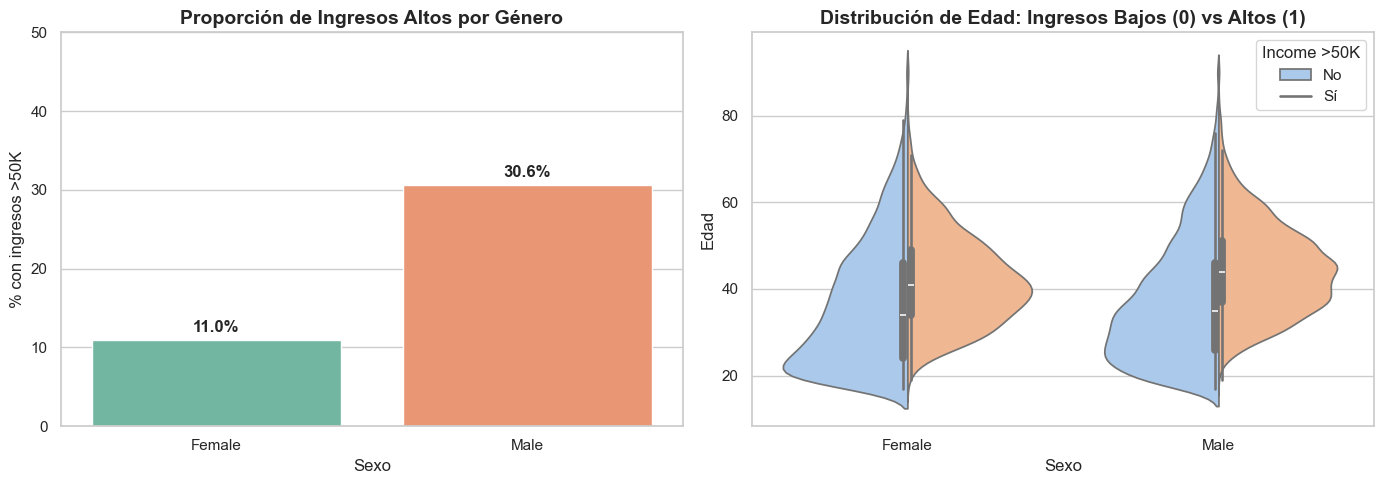

💡 INSIGHT 1: BRECHA DE GÉNERO

📊 Diferencia: 19.6 puntos porcentuales
🎯 Interpretación: Las mujeres tienen menor acceso a ingresos altos
✅ Acción: Programas de capacitación y mentoría enfocados en mujeres para sectores de alto ingreso


In [98]:
# Visualización 1: Brecha de género
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1.1 Proporción de ingresos >50K por sexo
gender_income = df.groupby('sex')['income_bin'].agg(['mean', 'count']).reset_index()
gender_income['mean'] = gender_income['mean'] * 100

sns.barplot(data=gender_income, x='sex', y='mean', palette='Set2', ax=axes[0])
axes[0].set_ylabel('% con ingresos >50K', fontsize=12)
axes[0].set_xlabel('Sexo', fontsize=12)
axes[0].set_title('Proporción de Ingresos Altos por Género', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 50)

# Añadir valores en barras
for i, row in gender_income.iterrows():
    axes[0].text(i, row['mean'] + 1, f"{row['mean']:.1f}%", 
                ha='center', fontweight='bold')

# 1.2 Distribución de edad por sexo e ingresos
sns.violinplot(data=df, x='sex', y='age', hue='income_bin', 
               split=True, palette='pastel', ax=axes[1])
axes[1].set_ylabel('Edad', fontsize=12)
axes[1].set_xlabel('Sexo', fontsize=12)
axes[1].set_title('Distribución de Edad: Ingresos Bajos (0) vs Altos (1)', fontsize=14, fontweight='bold')
axes[1].legend(title='Income >50K', labels=['No', 'Sí'])

plt.tight_layout()
plt.show()

# 💡 Insight
print("=" * 60)
print("💡 INSIGHT 1: BRECHA DE GÉNERO")
print("=" * 60)
diff = gender_income.set_index('sex')['mean'].diff().iloc[-1]
print(f"\n📊 Diferencia: {abs(diff):.1f} puntos porcentuales")
print(f"🎯 Interpretación: {'Las mujeres tienen menor acceso a ingresos altos' if diff > 0 else 'Los hombres tienen menor acceso'}")
print(f"✅ Acción: Programas de capacitación y mentoría enfocados en mujeres para sectores de alto ingreso")
print("=" * 60)

### 🎓 Visualización 2: El Poder (Real) de la Educación

**Historia**: Se dice que "la educación es el camino al éxito", pero ¿cuánto impacta realmente en los ingresos? ¿Y es igual para todos?

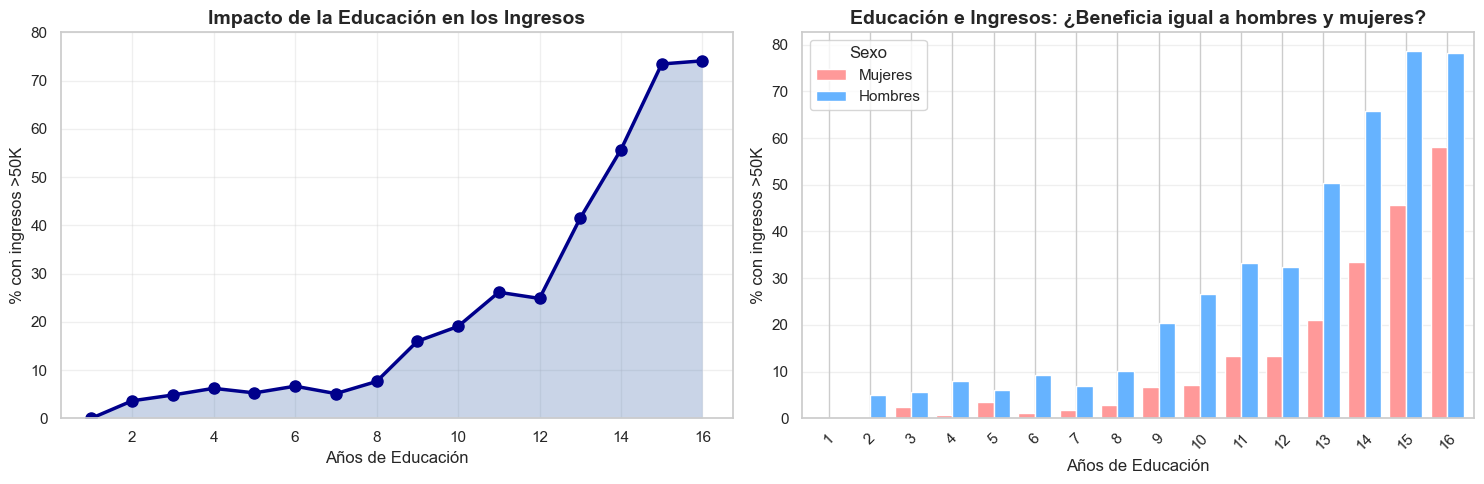

💡 INSIGHT 2: EDUCACIÓN Y EQUIDAD

📊 Educación básica (≤10 años): 15.0% con >50K
📊 Educación superior (≥13 años): 48.5% con >50K
📈 Impacto: +33.5 puntos porcentuales
⚠️ Pero: La brecha de género persiste incluso con educación alta
✅ Acción: Becas + acompañamiento laboral post-formación para grupos vulnerables


In [99]:
# Visualización 2: Educación e ingresos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 2.1 Proporción de ingresos >50K por nivel educativo
edu_income = df.groupby('education_num')['income_bin'].mean().reset_index()
edu_income['income_bin'] = edu_income['income_bin'] * 100

axes[0].plot(edu_income['education_num'], edu_income['income_bin'], 
            marker='o', linewidth=2.5, markersize=8, color='darkblue')
axes[0].fill_between(edu_income['education_num'], edu_income['income_bin'], alpha=0.3)
axes[0].set_xlabel('Años de Educación', fontsize=12)
axes[0].set_ylabel('% con ingresos >50K', fontsize=12)
axes[0].set_title('Impacto de la Educación en los Ingresos', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 80)

# 2.2 Educación vs Ingresos: diferencias por género
edu_gender = df.groupby(['education_num', 'sex'])['income_bin'].mean().unstack() * 100

edu_gender.plot(kind='bar', ax=axes[1], color=['#ff9999', '#66b3ff'], width=0.8)
axes[1].set_xlabel('Años de Educación', fontsize=12)
axes[1].set_ylabel('% con ingresos >50K', fontsize=12)
axes[1].set_title('Educación e Ingresos: ¿Beneficia igual a hombres y mujeres?', 
                 fontsize=14, fontweight='bold')
axes[1].legend(title='Sexo', labels=['Mujeres', 'Hombres'])
axes[1].set_xticklabels(edu_gender.index, rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 💡 Insight
print("=" * 60)
print("💡 INSIGHT 2: EDUCACIÓN Y EQUIDAD")
print("=" * 60)
low_edu = df[df['education_num'] <= 10]['income_bin'].mean() * 100
high_edu = df[df['education_num'] >= 13]['income_bin'].mean() * 100
print(f"\n📊 Educación básica (≤10 años): {low_edu:.1f}% con >50K")
print(f"📊 Educación superior (≥13 años): {high_edu:.1f}% con >50K")
print(f"📈 Impacto: +{high_edu - low_edu:.1f} puntos porcentuales")
print(f"⚠️ Pero: La brecha de género persiste incluso con educación alta")
print(f"✅ Acción: Becas + acompañamiento laboral post-formación para grupos vulnerables")
print("=" * 60)

### 💼 Visualización 3: Ocupaciones y Desigualdad

**Historia**: No todas las ocupaciones ofrecen las mismas oportunidades. ¿Qué sectores concentran la desigualdad?

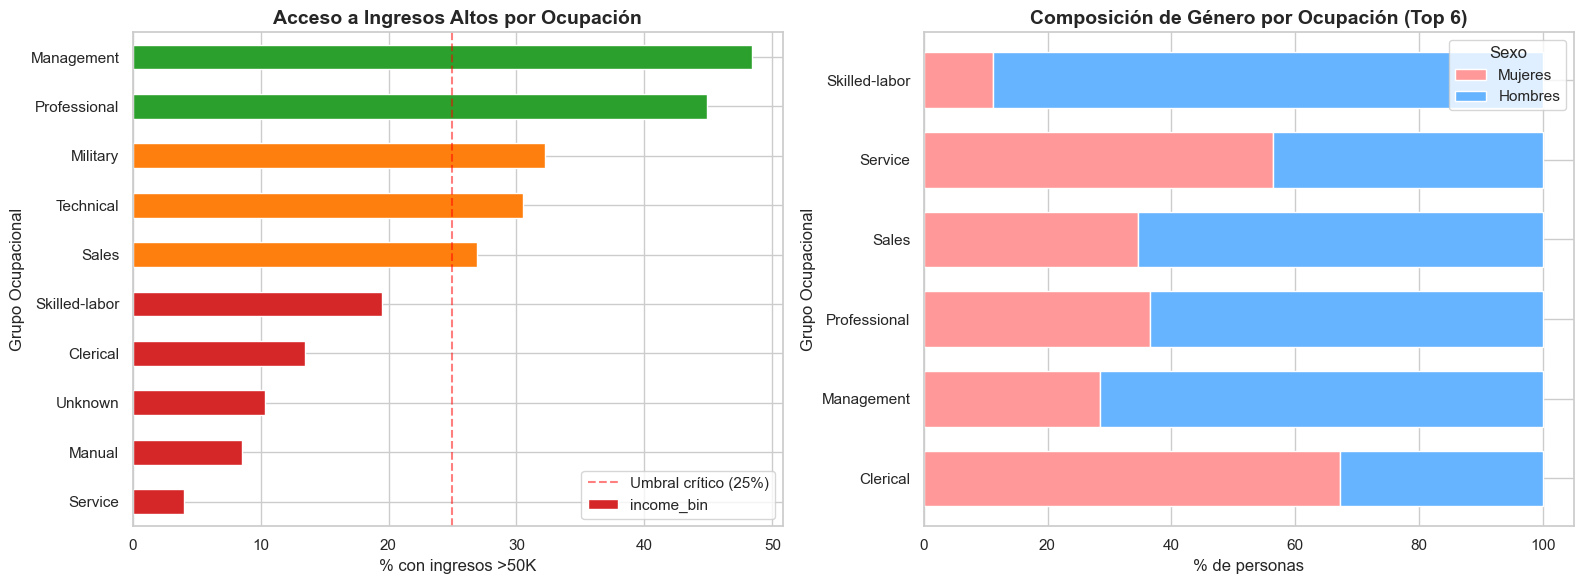

💡 INSIGHT 3: SEGREGACIÓN OCUPACIONAL

🔴 Ocupaciones de bajo acceso (<25%): Service, Manual, Unknown, Clerical, Skilled-labor
🟢 Ocupaciones de alto acceso (>40%): Professional, Management

⚠️ Observación: Sectores como 'Service' y 'Manual' concentran bajos ingresos
✅ Acción: Upskilling dirigido + reconversión profesional hacia sectores técnicos/profesionales


In [100]:
# Visualización 3: Ocupaciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 3.1 Proporción de ingresos >50K por grupo ocupacional
occ_income = df.groupby('occ_group').agg({
    'income_bin': 'mean',
    'occ_group': 'count'
}).rename(columns={'occ_group': 'count'})
occ_income['income_bin'] = occ_income['income_bin'] * 100
occ_income = occ_income.sort_values('income_bin', ascending=True)

colors = ['#d62728' if x < 25 else '#ff7f0e' if x < 35 else '#2ca02c' 
          for x in occ_income['income_bin']]

occ_income['income_bin'].plot(kind='barh', ax=axes[0], color=colors)
axes[0].set_xlabel('% con ingresos >50K', fontsize=12)
axes[0].set_ylabel('Grupo Ocupacional', fontsize=12)
axes[0].set_title('Acceso a Ingresos Altos por Ocupación', fontsize=14, fontweight='bold')
axes[0].axvline(x=25, color='red', linestyle='--', alpha=0.5, label='Umbral crítico (25%)')
axes[0].legend()

# 3.2 Distribución de género por ocupación (top 6)
top_occ = df['occ_group'].value_counts().head(6).index
occ_gender = df[df['occ_group'].isin(top_occ)].groupby(['occ_group', 'sex']).size().unstack(fill_value=0)
occ_gender_pct = occ_gender.div(occ_gender.sum(axis=1), axis=0) * 100

occ_gender_pct.plot(kind='barh', stacked=True, ax=axes[1], 
                    color=['#ff9999', '#66b3ff'], width=0.7)
axes[1].set_xlabel('% de personas', fontsize=12)
axes[1].set_ylabel('Grupo Ocupacional', fontsize=12)
axes[1].set_title('Composición de Género por Ocupación (Top 6)', fontsize=14, fontweight='bold')
axes[1].legend(title='Sexo', labels=['Mujeres', 'Hombres'])

plt.tight_layout()
plt.show()

# 💡 Insight
print("=" * 60)
print("💡 INSIGHT 3: SEGREGACIÓN OCUPACIONAL")
print("=" * 60)
low_income_occ = occ_income[occ_income['income_bin'] < 25].index.tolist()
high_income_occ = occ_income[occ_income['income_bin'] > 40].index.tolist()
print(f"\n🔴 Ocupaciones de bajo acceso (<25%): {', '.join(low_income_occ)}")
print(f"🟢 Ocupaciones de alto acceso (>40%): {', '.join(high_income_occ)}")
print(f"\n⚠️ Observación: Sectores como 'Service' y 'Manual' concentran bajos ingresos")
print(f"✅ Acción: Upskilling dirigido + reconversión profesional hacia sectores técnicos/profesionales")
print("=" * 60)

### ⏰ Visualización 4: La Trampa del Trabajo Intensivo

**Historia**: ¿Más horas trabajadas = más ingresos? No siempre. Veamos la relación entre esfuerzo y recompensa.

C:\Users\usuario\AppData\Local\Temp\ipykernel_8196\615060451.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='income_label', y='hours_per_week',


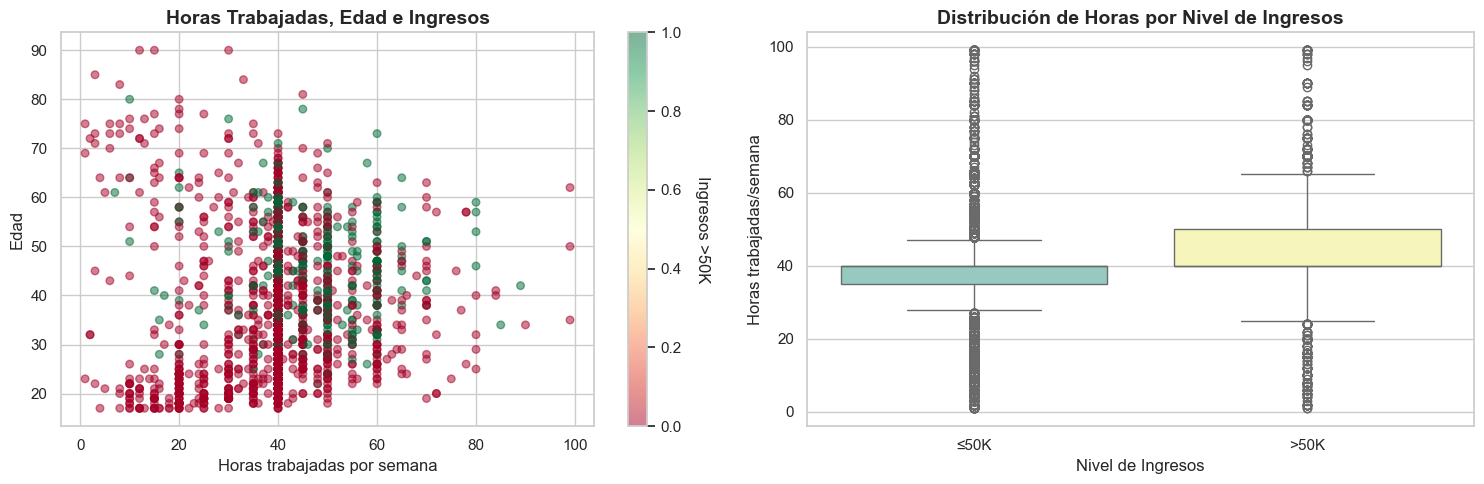

💡 INSIGHT 4: TRABAJO INTENSIVO ≠ BUENOS INGRESOS

📊 Horas mediana (≤50K): 40h/semana
📊 Horas mediana (>50K): 40h/semana
⚠️ Paradoja: Mucha gente trabaja muchas horas pero gana poco
🎯 Causa probable: Tipo de trabajo (manual/servicio) más que cantidad de horas
✅ Acción: Formación en habilidades de alto valor agregado, no solo 'trabajar más'


In [101]:
# Visualización 4: Horas trabajadas vs ingresos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 4.1 Scatter plot: horas vs ingresos (muestra)
sample_df = df.sample(min(2000, len(df)), random_state=42)
scatter = axes[0].scatter(sample_df['hours_per_week'], 
                         sample_df['age'],
                         c=sample_df['income_bin'], 
                         cmap='RdYlGn', 
                         alpha=0.5, 
                         s=30)
axes[0].set_xlabel('Horas trabajadas por semana', fontsize=12)
axes[0].set_ylabel('Edad', fontsize=12)
axes[0].set_title('Horas Trabajadas, Edad e Ingresos', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Ingresos >50K', rotation=270, labelpad=20)

# 4.2 Box plot: distribución de horas por nivel de ingresos
df['income_label'] = df['income_bin'].map({0: '≤50K', 1: '>50K'})
sns.boxplot(data=df, x='income_label', y='hours_per_week', 
            palette='Set3', ax=axes[1])
axes[1].set_xlabel('Nivel de Ingresos', fontsize=12)
axes[1].set_ylabel('Horas trabajadas/semana', fontsize=12)
axes[1].set_title('Distribución de Horas por Nivel de Ingresos', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 💡 Insight
print("=" * 60)
print("💡 INSIGHT 4: TRABAJO INTENSIVO ≠ BUENOS INGRESOS")
print("=" * 60)
low_inc_hours = df[df['income_bin'] == 0]['hours_per_week'].median()
high_inc_hours = df[df['income_bin'] == 1]['hours_per_week'].median()
print(f"\n📊 Horas mediana (≤50K): {low_inc_hours:.0f}h/semana")
print(f"📊 Horas mediana (>50K): {high_inc_hours:.0f}h/semana")
print(f"⚠️ Paradoja: Mucha gente trabaja muchas horas pero gana poco")
print(f"🎯 Causa probable: Tipo de trabajo (manual/servicio) más que cantidad de horas")
print(f"✅ Acción: Formación en habilidades de alto valor agregado, no solo 'trabajar más'")
print("=" * 60)

### 🎯 Visualización 5: El Impacto de los Datos Faltantes (Occupation Missing)

**Historia**: Las personas sin ocupación registrada (desempleados, trabajo informal) son un grupo vulnerable. ¿Qué tan grande es este grupo?

C:\Users\usuario\AppData\Local\Temp\ipykernel_8196\3187735160.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_income.index, y=missing_income.values,


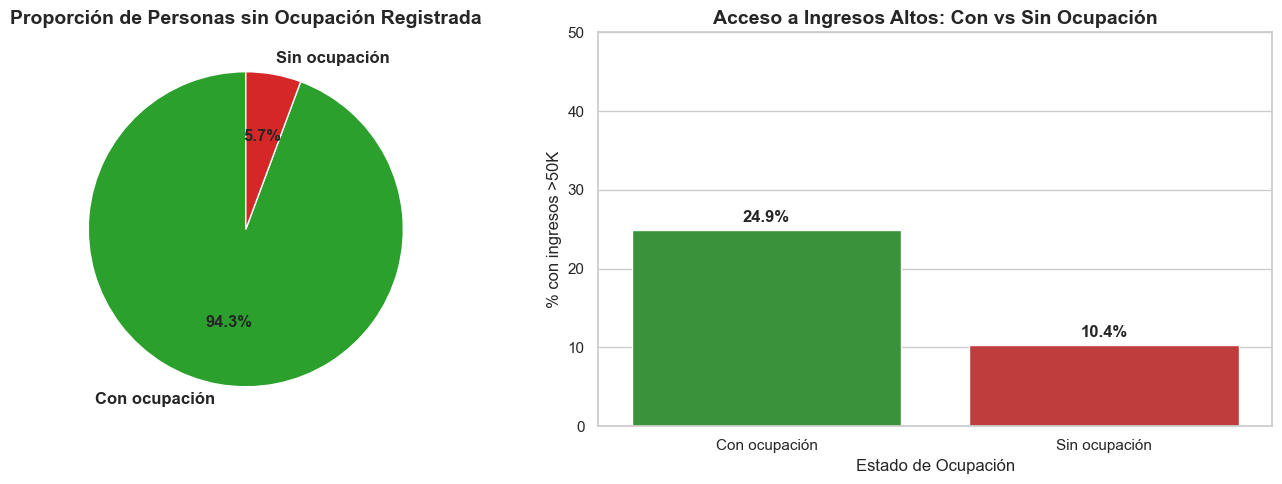

💡 INSIGHT 5: POBLACIÓN VULNERABLE SIN OCUPACIÓN

📊 Personas sin ocupación registrada: 1,843 (5.7%)
📊 Tasa de >50K con ocupación: 24.9%
📊 Tasa de >50K sin ocupación: 10.4%
⚠️ Gap: 14.6 puntos porcentuales
🎯 Grupo prioritario: Desempleados, trabajo informal, transición laboral
✅ Acción: Programas de inserción laboral + formación técnica acelerada


In [102]:
# Visualización 5: Impacto de occupation_missing
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 5.1 Proporción de casos sin ocupación
missing_counts = df['occupation_missing'].value_counts()
colors_pie = ['#2ca02c', '#d62728']
axes[0].pie(missing_counts, labels=['Con ocupación', 'Sin ocupación'], 
           autopct='%1.1f%%', colors=colors_pie, startangle=90,
           textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Proporción de Personas sin Ocupación Registrada', 
                 fontsize=14, fontweight='bold')

# 5.2 Tasa de ingresos >50K: con vs sin ocupación
missing_income = df.groupby('occupation_missing')['income_bin'].mean() * 100
missing_income.index = ['Con ocupación', 'Sin ocupación']

sns.barplot(x=missing_income.index, y=missing_income.values, 
           palette=['#2ca02c', '#d62728'], ax=axes[1])
axes[1].set_ylabel('% con ingresos >50K', fontsize=12)
axes[1].set_xlabel('Estado de Ocupación', fontsize=12)
axes[1].set_title('Acceso a Ingresos Altos: Con vs Sin Ocupación', 
                 fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 50)

# Añadir valores
for i, v in enumerate(missing_income.values):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 💡 Insight
print("=" * 60)
print("💡 INSIGHT 5: POBLACIÓN VULNERABLE SIN OCUPACIÓN")
print("=" * 60)
n_missing = df['occupation_missing'].sum()
pct_missing = (n_missing / len(df)) * 100
income_with = df[df['occupation_missing'] == 0]['income_bin'].mean() * 100
income_without = df[df['occupation_missing'] == 1]['income_bin'].mean() * 100
print(f"\n📊 Personas sin ocupación registrada: {n_missing:,} ({pct_missing:.1f}%)")
print(f"📊 Tasa de >50K con ocupación: {income_with:.1f}%")
print(f"📊 Tasa de >50K sin ocupación: {income_without:.1f}%")
print(f"⚠️ Gap: {income_with - income_without:.1f} puntos porcentuales")
print(f"🎯 Grupo prioritario: Desempleados, trabajo informal, transición laboral")
print(f"✅ Acción: Programas de inserción laboral + formación técnica acelerada")
print("=" * 60)

---

## 📝 Resumen Ejecutivo: Hallazgos Clave para Inclusión

### 🎯 Los 5 Insights Principales

1. **Brecha de Género Persistente**: Las mujeres tienen significativamente menor acceso a ingresos altos, incluso con educación equivalente
   
2. **La Educación Importa (pero no es suficiente)**: Cada año adicional de educación aumenta las probabilidades, pero no elimina otras desigualdades

3. **Segregación Ocupacional**: Sectores como Service y Manual concentran bajos ingresos; Professional y Management ofrecen mejores oportunidades

4. **Trabajo ≠ Recompensa**: Muchas personas trabajan muchas horas pero permanecen en bajos ingresos (tipo de trabajo > cantidad de horas)

5. **Población Vulnerable Sin Ocupación**: ~6% sin ocupación registrada tienen tasas dramáticamente bajas de acceso a buenos ingresos

### ✅ Acciones Recomendadas

| Grupo Objetivo | Intervención | Prioridad |
|----------------|--------------|-----------|
| **Mujeres en sectores de bajo ingreso** | Programas de upskilling + mentoría en sectores técnicos/profesionales | 🔴 ALTA |
| **Trabajadores manuales/servicio** | Reconversión profesional + certificaciones técnicas | 🔴 ALTA |
| **Personas sin ocupación formal** | Inserción laboral acelerada + formación básica | 🔴 ALTA |
| **Jóvenes con educación básica** | Becas para educación superior + prácticas pagadas | 🟡 MEDIA |
| **Personas 45+ en transición** | Formación en habilidades digitales + networking | 🟡 MEDIA |

### 🚀 Próximos Pasos

1. **Modelado Predictivo**: Entrenar modelo para identificar personas en riesgo de bajos ingresos
2. **Fairness Analysis**: Medir sesgos del modelo por género, edad y ocupación
3. **Intervenciones Personalizadas**: Sistema de recomendación de formación según perfil
4. **A/B Testing**: Probar efectividad de programas de inclusión con grupo control